In [33]:
import numpy as np
import pandas as pd

In [34]:
x_train = np.load("../data/preserve10/x_train.npy")
y_train = np.load("../data/preserve10/y_train.npy")
x_test = np.load("../data/preserve10/x_test.npy")
y_test = np.load("../data/preserve10/y_test.npy")

In [35]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (212091, 31)
y_train (212091, 1)
x_test (70697, 31)
y_test (70697, 1)


In [36]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy", 
    mode='max', 
    patience=5, 
    min_delta=0.0001
)

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters
latent_dim = 50  # Latent space dimension
learning_rate = 0.0002
batch_size = 64
epochs = 1  # Adjust based on computational resources
weight_decay = 1e-5  # Regularization factor

# Assuming your data is preprocessed: x_train, y_train, x_test, y_test
input_dim = x_train.shape[1]  # 31 input features
num_classes = len(np.unique(y_train))  # Number of unique classes

# Calculate class distribution
unique_classes, class_counts = np.unique(y_train, return_counts=True)
majority_class_count = np.max(class_counts)
minority_classes = unique_classes[class_counts < majority_class_count]

# VAE Model definition
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, input_dim):
        super(VAE, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
            layers.Dense(latent_dim + latent_dim),
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
            layers.Dense(input_dim, activation='sigmoid'),
        ])
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean
    def decode(self, z):
        return self.decoder(z)

# CGAN Generator definition
class CGANGenerator(tf.keras.Model):
    def __init__(self, latent_dim, num_classes, input_dim):
        super(CGANGenerator, self).__init__()
        self.label_embedding = layers.Embedding(num_classes, num_classes)
        self.model = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim + num_classes,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid'),
        ])
    def call(self, z, labels):
        label_input = tf.reshape(self.label_embedding(labels), (tf.shape(z)[0], -1))
        input_concat = tf.concat([z, label_input], axis=1)
        return self.model(input_concat)

# CGAN Discriminator definition
class CGANDiscriminator(tf.keras.Model):
    def __init__(self, num_classes, input_dim):
        super(CGANDiscriminator, self).__init__()
        self.label_embedding = layers.Embedding(num_classes, num_classes)
        self.model = models.Sequential([
            layers.InputLayer(input_shape=(input_dim + num_classes,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
    def call(self, x, labels):
        label_input = tf.reshape(self.label_embedding(labels), (tf.shape(x)[0], -1))
        input_concat = tf.concat([x, label_input], axis=1)
        return self.model(input_concat)

# Initialize models and optimizers
vae = VAE(latent_dim, input_dim)
cgan_gen = CGANGenerator(latent_dim, num_classes, input_dim)
cgan_disc = CGANDiscriminator(num_classes, input_dim)

vae_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)


# Define training steps and gradient penalty (same as original code)
def gradient_penalty(discriminator, real_samples, fake_samples, labels):
    """Calculates the gradient penalty for WGAN-GP"""
    # Ensure the correct data type (float32) for all inputs
    real_samples = tf.cast(real_samples, tf.float32)
    fake_samples = tf.cast(fake_samples, tf.float32)
    alpha = tf.random.uniform([tf.shape(real_samples)[0], 1], 0.0, 1.0)
    alpha = tf.cast(alpha, tf.float32)
    
    # Interpolated samples
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        interpolated_output = discriminator(interpolated, labels)
    grads = gp_tape.gradient(interpolated_output, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

@tf.function
def train_step(vae, cgan_gen, cgan_disc, x_batch, y_batch, shuffle_labels=False):
    # Ensure inputs are cast to float32
    x_batch = tf.cast(x_batch, tf.float32)
    y_batch = tf.cast(y_batch, tf.float32)

    batch_size_actual = tf.shape(x_batch)[0]
    if shuffle_labels:
        # Shuffle labels for supervised adversarial training
        indices = tf.random.shuffle(tf.range(start=0, limit=batch_size_actual, dtype=tf.int32))
        y_batch = tf.gather(y_batch, indices)
    y_batch_flat = tf.squeeze(y_batch, axis=-1)

    with tf.GradientTape(persistent=True) as tape:
        # VAE forward pass
        mean, logvar = vae.encode(x_batch)
        z = vae.reparameterize(mean, logvar)
        x_reconstructed = vae.decode(z)
        vae_loss = losses.binary_crossentropy(x_batch, x_reconstructed)

        # CGAN generator forward pass
        z_fake = tf.random.normal(shape=(batch_size_actual, latent_dim))  # Adjust z_fake size
        gen_output = cgan_gen(z_fake, y_batch_flat)
        disc_fake_output = cgan_disc(gen_output, y_batch_flat)
        gen_loss = -tf.reduce_mean(disc_fake_output)

        # CGAN discriminator forward pass with WGAN-GP loss
        disc_real_output = cgan_disc(x_batch, y_batch_flat)
        disc_fake_output = cgan_disc(gen_output, y_batch_flat)
        gp = gradient_penalty(cgan_disc, x_batch, gen_output, y_batch_flat)
        disc_loss = -tf.reduce_mean(disc_real_output) + tf.reduce_mean(disc_fake_output) + 10.0 * gp

    # Apply gradients
    gradients_of_discriminator = tape.gradient(disc_loss, cgan_disc.trainable_variables)
    gradients_of_generator = tape.gradient(gen_loss, cgan_gen.trainable_variables)
    gradients_of_vae = tape.gradient(vae_loss, vae.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, cgan_disc.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, cgan_gen.trainable_variables))
    vae_optimizer.apply_gradients(zip(gradients_of_vae, vae.trainable_variables))

# Training loop for VAE and CGAN
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        train_step(vae, cgan_gen, cgan_disc, x_batch, y_batch)
    
    print(f"Epoch {epoch + 1}/{epochs} completed.")

# Generate synthetic samples for each minority class
synthetic_samples = []
synthetic_labels = []

# Generate synthetic samples for minority classes using the trained CGAN
def generate_synthetic_samples(cgan_gen, num_samples, label):
    z_new = tf.random.normal(shape=(num_samples, latent_dim))
    labels = np.full(num_samples, label)
    return cgan_gen(z_new, labels)

for minority_class in minority_classes:
    samples_needed = majority_class_count - class_counts[minority_class]
    generated_samples = generate_synthetic_samples(cgan_gen, samples_needed, minority_class)
    synthetic_samples.append(generated_samples)
    synthetic_labels.extend([minority_class] * samples_needed)

# Combine synthetic samples with original data
synthetic_labels = np.array(synthetic_labels).reshape(-1, 1)
# Combine synthetic samples with original data
synthetic_samples = np.vstack(synthetic_samples)  # Stack synthetic samples vertically to form a 2D array
x_train_balanced = np.concatenate([x_train, synthetic_samples], axis=0)
y_train_balanced = np.concatenate([y_train, synthetic_labels], axis=0)

# Encode both real and synthetic data using VAE
x_train_encoded = vae.encode(x_train_balanced)[0]  # Use the mean from VAE encoder
x_test_encoded = vae.encode(x_test)[0]

# Train the classifier on the encoded balanced dataset
classifier = models.Sequential([
    layers.InputLayer(input_shape=(latent_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x_train_encoded, y_train_balanced, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the classifier on the training
results = classifier.evaluate(x_train_encoded, y_train_balanced)
print(f"Training Accuracy: {results[1] * 100:.2f}%")

# Evaluate the classifier on the test set
results = classifier.evaluate(x_test_encoded, y_test)
print(f"Test Accuracy: {results[1] * 100:.2f}%")

Epoch 1/1 completed.
35889/35889 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - accuracy: 0.0744 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
79753/79753 ━━━━━━━━━━━━━━━━━━━━ 76s 951us/step - accuracy: 0.2322 - loss: nan
Training Accuracy: 6.67%
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - accuracy: 0.8043 - loss: nan
Test Accuracy: 80.34%


In [38]:
x_train_encoded.shape

TensorShape([2552085, 50])

In [39]:
y_train_balanced.shape

(2552085, 1)

In [40]:
y_train_balanced_onehot = tf.keras.utils.to_categorical(y_train_balanced, num_classes=15)

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(latent_dim,)),  
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15, activation="softmax")
])


model.compile(optimizer="adamax",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(x_train_encoded,
          y_train_balanced_onehot,
          epochs=1,
          callbacks=[earlystop_callback],
          batch_size=128
         )

# Evaluate the classifier on the training
results = classifier.evaluate(x_train_encoded, y_train_balanced)
print(f"Training Accuracy: {results[1] * 100:.2f}%")

# Evaluate the classifier on the test set
results = classifier.evaluate(x_test_encoded, y_test)
print(f"Test Accuracy: {results[1] * 100:.2f}%")

19939/19939 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.0667 - loss: nan
79753/79753 ━━━━━━━━━━━━━━━━━━━━ 75s 935us/step - accuracy: 0.2323 - loss: nan
Training Accuracy: 6.67%
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.8043 - loss: nan
Test Accuracy: 80.34%


In [41]:
# Before SMOTE
print("Class distribution in original data:")
original_counts = pd.Series(y_train.flatten()).value_counts().sort_index()  # Flatten and sort by index (class label)
print(original_counts)

# After SMOTE
print("Class distribution after applying SMOTE:")
smote_counts = pd.Series(y_train_balanced.flatten()).value_counts().sort_index()  # Flatten and sort by index (class label)
print(smote_counts)

Class distribution in original data:
0     170139
1        134
2       9639
3        773
4      17440
5        424
6        419
7        570
8          2
9          4
10     11954
11       428
12       118
13         1
14        46
Name: count, dtype: int64
Class distribution after applying SMOTE:
0     170139
1     170139
2     170139
3     170139
4     170139
5     170139
6     170139
7     170139
8     170139
9     170139
10    170139
11    170139
12    170139
13    170139
14    170139
Name: count, dtype: int64


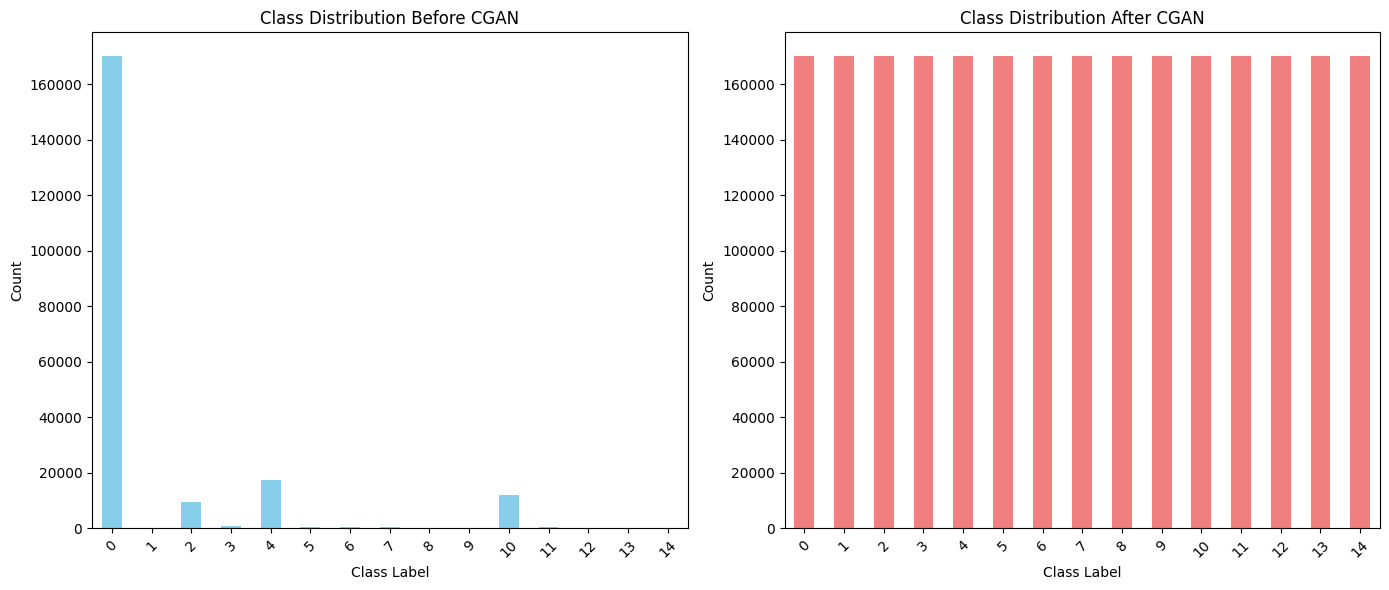

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Class distribution before CGAN
original_counts = pd.Series(y_train.flatten()).value_counts().sort_index()

# Class distribution after CGAN
cgan_counts = pd.Series(y_train_balanced.flatten()).value_counts().sort_index()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot before CGAN
original_counts.sort_index().plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Class Distribution Before CGAN')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(original_counts.index, rotation=45)

# Plot after CGAN
cgan_counts.sort_index().plot(kind='bar', ax=ax[1], color='lightcoral')
ax[1].set_title('Class Distribution After CGAN')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Count')
ax[1].set_xticklabels(cgan_counts.index, rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8042 - loss: nan
Test Accuracy: 0.8034
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step


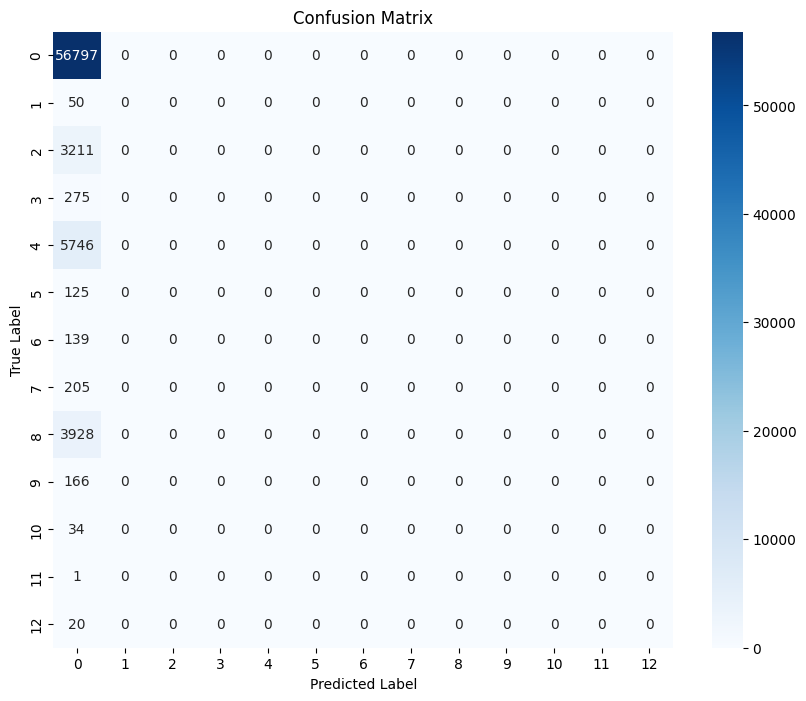

In [44]:
# Evaluate the model on the test data (you can also use x_train and y_train to evaluate training accuracy)
loss, accuracy = classifier.evaluate(x_test_encoded, y_test, batch_size=128)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = classifier.predict(x_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


2210/2210 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/work1/anaconda3/envs/vae-cgan1/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/work1/anaconda3/envs/vae-cgan1/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


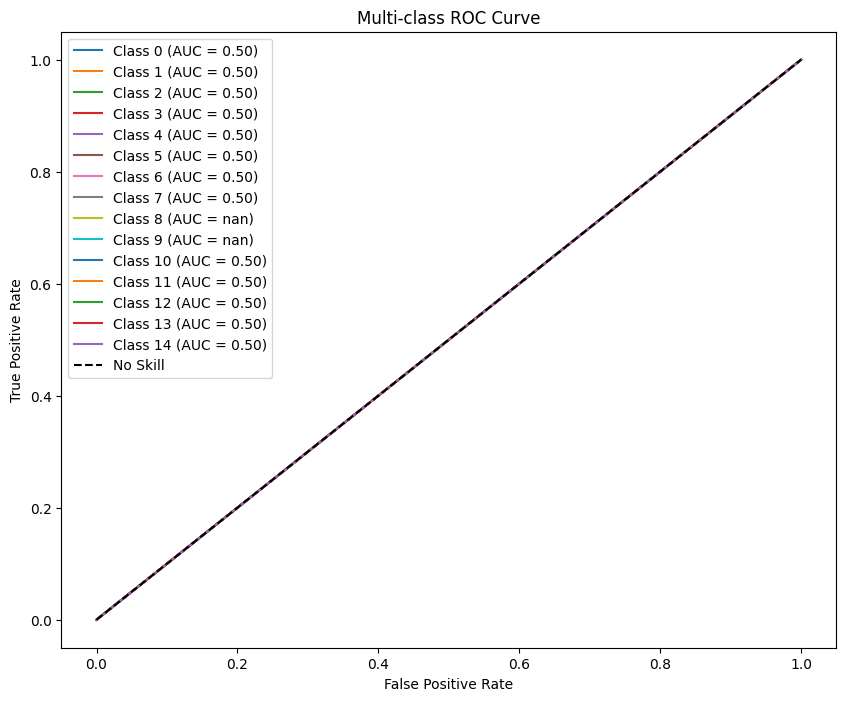

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming `num_classes` is the total number of classes
# Binarize the output for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

# Step 1: Get predicted probabilities from the classifier
y_pred_prob = classifier.predict(x_test_encoded)  # Probabilities for each class

y_test_binarized = np.nan_to_num(y_test_binarized, nan=0)
y_pred_prob = np.nan_to_num(y_pred_prob, nan=0)

# Step 2: Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (no-skill classifier)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

# Finalize the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="best")
plt.show()

2210/2210 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step


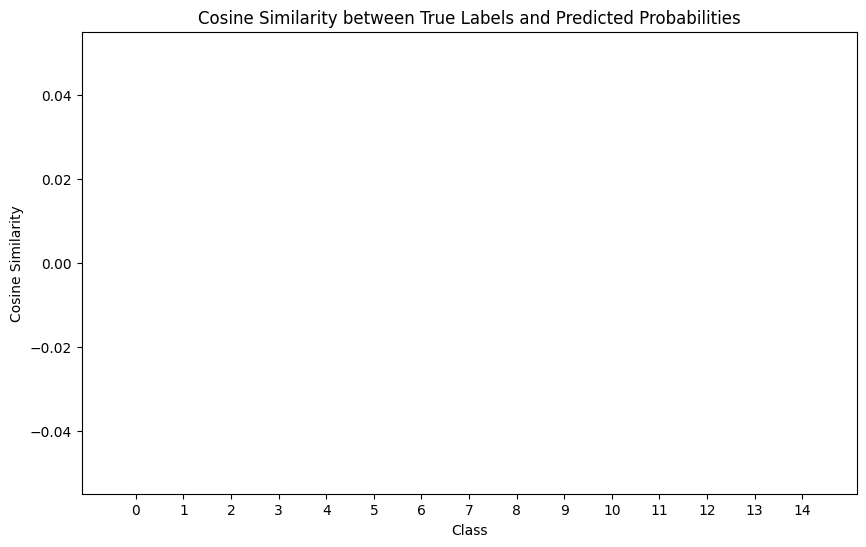

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Assuming `num_classes` is the total number of classes
# Binarize the output for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

# Step 1: Get predicted probabilities from the classifier
y_pred_prob = classifier.predict(x_test_encoded)  # Probabilities for each class

# Ensure no NaN values in the datasets
y_test_binarized = np.nan_to_num(y_test_binarized, nan=0)
y_pred_prob = np.nan_to_num(y_pred_prob, nan=0)

# Step 2: Compute Cosine Similarity between predicted probabilities and actual labels
cosine_similarities = []

for i in range(num_classes):
    similarity = cosine_similarity([y_test_binarized[:, i]], [y_pred_prob[:, i]])[0][0]
    cosine_similarities.append(similarity)


# Step 4: Plot the Cosine Similarity for each class
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), cosine_similarities, color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between True Labels and Predicted Probabilities')
plt.xticks(range(num_classes))
plt.show()
